# Multilabel classification problem solution for Reuters-21578

In [2]:
import numpy as np
import pandas as pd
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import nltk # text cleaning and datasets 
import re # patterns searching in strings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix, hamming_loss

#### Import data from nltk.corpus and establish train/test inputs and targets

In [955]:
from nltk.corpus import reuters

In [1087]:
all_docs = reuters.fileids()
train_doc_names = [doc for doc in all_docs if doc.startswith("train")]
test_doc_names = [doc for doc in all_docs if doc.startswith("test")]

In [1088]:
X_train_raw, y_train_raw = zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in train_doc_names])
X_test_raw, y_test_raw= zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in test_doc_names])

### Review the data:

In [1089]:
# Number of articles:
print(f"Number of train articles: {len(X_train_raw)}")
print(f"Number of test articles: {len(X_test_raw)}")

Number of train articles: 7769
Number of test articles: 3019


#### Review labels

In [1090]:
y_train_raw_flat = pd.Series(itertools.chain(*y_train_raw))
y_test_raw_flat = pd.Series(itertools.chain(*y_train_raw))

In [960]:
print(f"Avg number of labels per article in train set: {(len(y_train_raw_flat) / len(y_train_raw) ):.2f}")
# print(f"Avg number of labels per article in test set: {(len(y_test_raw_flat) / len(y_test_raw) ):.2f}")

Avg number of labels per article in train set: 1.23


In [961]:
# Count number of labels for each article
labels_len = [len(labels) for labels in y_train_raw]
# Group 
labels_freq = {n: labels_len.count(n) for n in labels_len}
labels_freq = dict(sorted(labels_freq.items()))
print(f"Number of labels assigned to article: Total number of such occurances")
labels_freq

Number of labels assigned to article: Total number of such occurances


{1: 6577,
 2: 865,
 3: 192,
 4: 59,
 5: 37,
 6: 22,
 7: 5,
 8: 5,
 9: 3,
 10: 2,
 11: 1,
 15: 1}

Conclusion: For most of the cases in the train set - there is only 1 label associated with article.

#### Review classes

In [962]:
print(f"Total number of classes: {len(reuters.categories())}")

Total number of classes: 90


In [963]:
cat_distr = y_train_raw_flat.value_counts()
cat_distr.head(5)

earn        2877
acq         1650
money-fx     538
grain        433
crude        389
dtype: int64

In [964]:
cat_distr.tail(5)

sun-meal         1
castor-oil       1
groundnut-oil    1
nkr              1
lin-oil          1
dtype: int64

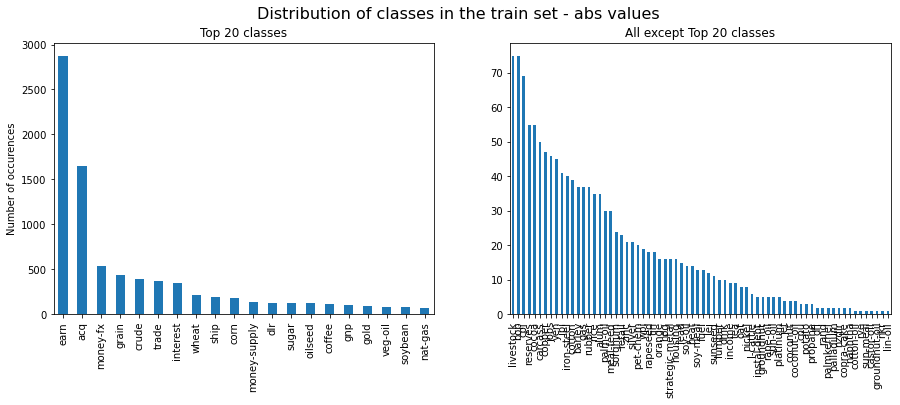

In [965]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - abs values', fontsize = 16)

plt.subplot(1,2,1)
cat_distr[:n].plot.bar()
plt.ylabel(f'Number of occurences');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
cat_distr[n:].plot.bar()
plt.title(f'All except Top {n} classes');

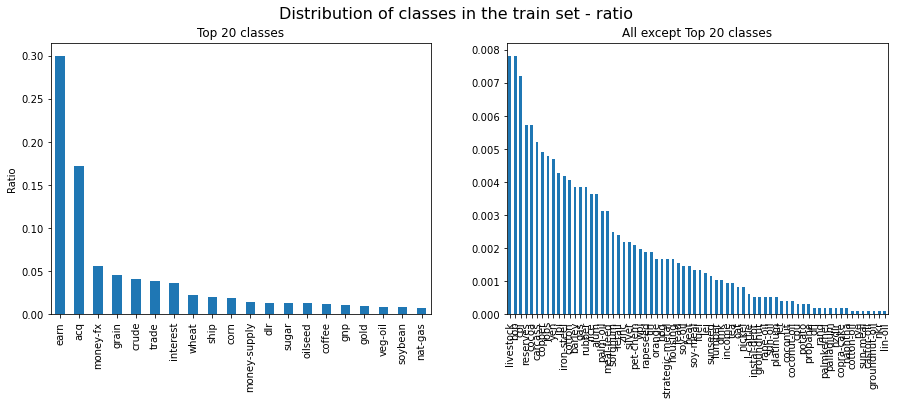

In [966]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - ratio', fontsize = 16)

plt.subplot(1,2,1)
(cat_distr[:n]/cat_distr.sum()).plot.bar()
plt.ylabel(f'Ratio');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
(cat_distr[n:]/cat_distr.sum()).plot.bar()
plt.title(f'All except Top {n} classes');

Conclusion: Top 2 classes are far more frequent than other classes (more than 45% of all targets)

#### Review the raw articles

In [967]:
type(X_train_raw[0])

str

In [968]:
art_len = [len(art) for art in X_train_raw]

In [969]:
print(f"Character count for the shortest article: {min(art_len)}")
print(f"Character count for the longest article: {max(art_len)}")

Character count for the shortest article: 27
Character count for the longest article: 8898


In [970]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# ax1.hist(art_len, bins=50, rwidth = 0.9);

(0.0, 200.0)

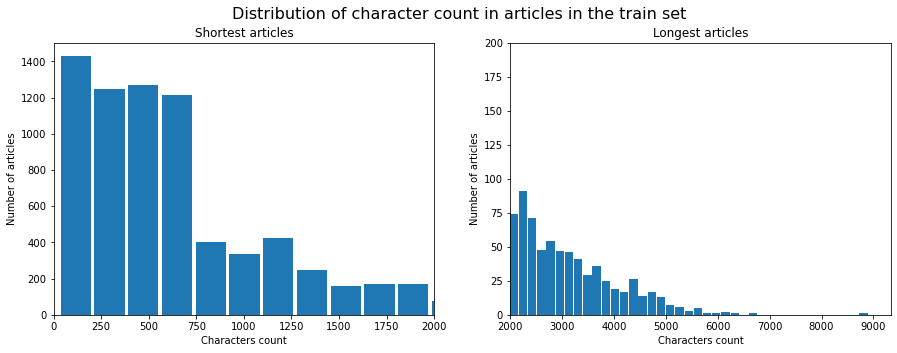

In [971]:
n=2000 # split between left and right graph (number of characters)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of character count in articles in the train set', fontsize = 16)

plt.subplot(1,2,1)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Shortest articles');
plt.xlim(0,n)

plt.subplot(1,2,2)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Longest articles');
plt.xlim(n,)
plt.ylim(0,200)

# plt.tight_layout()
# ax.set(ylabel = 'aaa')

In [972]:
X_train_raw[0][:300]

'BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry p'

<br><br><br>
### Side analysis START

In [973]:
min(X_train_raw, key=len)

'26-FEB-1987\n  26-FEB-1987\n\n'

In [974]:
min(X_train_raw)

' 1-APR-1987 17:39:30.41\n   1-APR-1987 17:39:30.41\n\n'

In [975]:
X_train_raw.index(min(X_train_raw, key=len))

66

In [976]:
X_train_raw.index(min(X_train_raw))

1533

In [977]:
y_train_raw[1533]

['grain', 'ship']

In [978]:
y_train_raw[66]

['money-supply']

### Side analysis END

<br><br><br>
### Clean text

#### Functions definition

In [1111]:
def remove_html(text_list):
    text_clean = [re.sub("<.+?>", " ", el) for el in text]
    return text_clean

In [1112]:
def convert_to_lower(text):
    text_clean = [el.lower() for el in text]
    return text_clean

In [1113]:
def remove_control_chars(text): # (e.g. \n \t...)
    text_clean = [re.sub("\s+", " ", el) for el in text]
    return text_clean

In [1114]:
def tokenization(text):
    text_clean = [nltk.word_tokenize(el) for el in text]
    return text_clean

In [1115]:
def remove_stopwords(text):
    stopwords =nltk.corpus.stopwords.words("english")
    text_clean = [[w for w in el if w not in stopwords] for el in text]
    return text_clean

In [1116]:
def remove_punctuations(text):
    import string
    punctuations = [char for char in string.punctuation]
    
    text_clean = [[w for w in el if w not in punctuations] for el in text]
    return text_clean

In [1117]:
def token_normalization(text):
    # Token normalization - stemming with PorterStemmer 
    # It is not important to keep "real" language words, so stemming (as being faster) is a better choice than lemmatization
    stemmer = nltk.PorterStemmer()
    
    text_clean = [[stemmer.stem(w) for w in el] for el in text]
    return text_clean

In [1118]:
def remove_numbers(text):
    
    text_clean = [[re.sub('[^A-Za-z]+', '', w) for w in el] for el in text]
    # Remove empty strings after number removal
    text_clean = [list(filter(None, el)) for el in text_clean]
    
    return text_clean

In [1119]:
def remove_short_words(text, k):
    text_clean = [[w for w in el if len(w) > k] for el in text]
    return text_clean

In [1120]:
def merge_back(text):
    text_merge = [" ".join(el) for el in text]
    return text_merge

In [1121]:
# Combine all functions above
def text_preprocess(text):
#     text = remove_html(text)
    text = convert_to_lower(text)
    text = remove_control_chars(text)
    tokens = tokenization(text)
    tokens = remove_stopwords(text)
    tokens = remove_punctuations(text)
    tokens = token_normalization(text)
    tokens = remove_numbers(text)
    text = remove_short_words(text, 2)
    text_final = merge_back(text)
    
    return tokens, text_final

#### Let's apply cleaning functions on train set:

In [1122]:
# Convert to lower case
X_train =  convert_to_lower(X_train_raw)
X_train[0][:300]

'bahia cocoa review\n  showers continued throughout the week in\n  the bahia cocoa zone, alleviating the drought since early\n  january and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  comissaria smith said in its weekly review.\n      the dry p'

In [1123]:
# Remove control characters
X_train =  remove_control_chars(X_train)
X_train[0][:300]

'bahia cocoa review showers continued throughout the week in the bahia cocoa zone, alleviating the drought since early january and improving prospects for the coming temporao, although normal humidity levels have not been restored, comissaria smith said in its weekly review. the dry period means the '

In [1124]:
# Tokenization
X_train = tokenization(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'the', 'drought', 'since', 'early', 'january']


In [1125]:
# Remove stopwords
X_train = remove_stopwords(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao']


In [1126]:
# Remove punctuations
X_train = remove_punctuations(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'although']


In [1127]:
# Token normalization
X_train = token_normalization(X_train)
print(X_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', '22', '155,221', 'bag', '60', 'kilo', 'make', 'cumul', 'total', 'season', '5.93', 'mln']


In [1128]:
# Remove numbers 
# Consider converting all numbers to "number" string instead of removing them ???
X_train = remove_numbers(X_train) 
print(X_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem']


In [1129]:
# Remove words shorter than 2
X_train = remove_short_words(X_train, 2)
print(X_train[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem', 'cocoa', 'deliv', 'earlier', 'consign', 'includ', 'arriv', 'figur', 'comissaria', 'smith', 'said']


In [1130]:
tokens_train = X_train

In [1131]:
X_train = merge_back(X_train)
X_train[0][:500]

'bahia cocoa review shower continu throughout week bahia cocoa zone allevi drought sinc earli januari improv prospect come temporao although normal humid level restor comissaria smith said weekli review dri period mean temporao late year arriv week end februari bag kilo make cumul total season mln stage last year seem cocoa deliv earlier consign includ arriv figur comissaria smith said still doubt much old crop cocoa still avail harvest practic come end total bahia crop estim around mln bag sale '

#### Let's do the same cleaning transofrmations with test set (using combined function)

In [1132]:
tokens_test, X_test = text_preprocess(X_test_raw)

In [1134]:
indexes = [word for doc in tokens_train for word in doc]  
print(f"There are {len(indexes)} words in the data corpus")

There are 596080 words in the data corpus


In [1135]:
from collections import Counter

In [1136]:
corpus_freq = Counter(indexes).most_common()
corpus_freq[:25]

[('said', 18844),
 ('mln', 13102),
 ('dlr', 9750),
 ('pct', 7406),
 ('year', 6010),
 ('net', 4566),
 ('loss', 4312),
 ('share', 4184),
 ('billion', 4110),
 ('compani', 4037),
 ('bank', 3871),
 ('would', 3411),
 ('shr', 3277),
 ('price', 3033),
 ('trade', 3012),
 ('inc', 2959),
 ('market', 2857),
 ('profit', 2753),
 ('oper', 2498),
 ('last', 2409),
 ('sale', 2406),
 ('corp', 2406),
 ('oil', 2396),
 ('rate', 2292),
 ('stock', 2252)]

In [1137]:
uniques = [word for word,freq in Counter(indexes).items() if freq == 1]

In [1140]:
len(uniques)

7983

<br><br><br>
## Text vectorization
Plan to review TFIDF, FastText, doc2vec

What about Skip-Thought Vectors??

### TFIDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer?

In [1001]:
min_df = 3
max_df = 0.6

In [1002]:
tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

tfidf = tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

In [1041]:
print(f"Number of remaining tokens: {X_train_tfidf.shape[1]}")

Number of remaining tokens: 7367


In [1004]:
# Take a dense tfidf with feature names
df_tfidf = pd.DataFrame(X_train_tfidf.todense().T, index=tfidf.get_feature_names())

In [1045]:
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768
aa,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aac,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ab,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoet,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.044532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zorinski,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuccherifici,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1077]:
doc = 0
df_tfidf.loc[df_tfidf[doc] > 0, [doc]]

,0
allevi,0.056779
almost,0.038599
also,0.020208
although,0.033910
aprilmay,0.055311
...,...
went,0.043404
would,0.019077
year,0.029058
york,0.258739


In [1060]:
df_tfidf.shape

(7367, 7769)

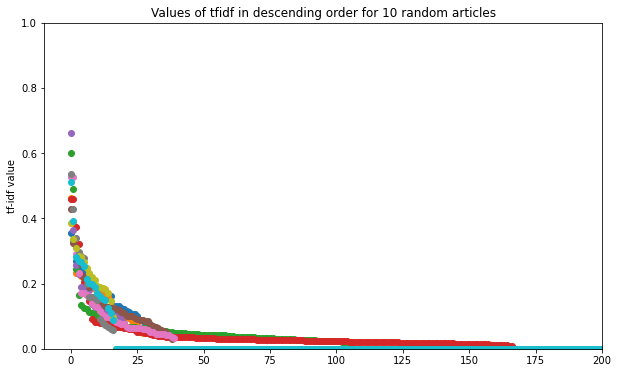

In [1008]:
import random
n = 10 # Number of articles to be presented
randomlist = random.sample(range(0, X_train_tfidf.shape[0]), n)

plt.figure(figsize=(10,6))

for i in randomlist:
    rowssort = X_train_tfidf.getrow(i).todense().A1.argsort()[::-1]
    valsort = df_tfidf[i].values[rowssort]
    
    plt.plot(valsort, 'o')

ax = plt.gca()
ax.set(xlim=(-10, 200), ylim=(0, 1),
       ylabel='tf-idf value',
       title=f'Values of tfidf in descending order for {n} random articles');


### Doc2vec

In [1080]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [1141]:
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens_train)]

In [1150]:
train_corpus[1]

TaggedDocument(words=['comput', 'termin', 'system', 'cpml', 'complet', 'sale', 'comput', 'termin', 'system', 'inc', 'said', 'complet', 'sale', 'share', 'common', 'stock', 'warrant', 'acquir', 'addit', 'one', 'mln', 'share', 'sedio', 'lugano', 'switzerland', 'dlr', 'compani', 'said', 'warrant', 'exercis', 'five', 'year', 'purchas', 'price', 'dlr', 'per', 'share', 'comput', 'termin', 'said', 'sedio', 'also', 'right', 'buy', 'addit', 'share', 'increas', 'total', 'hold', 'pct', 'comput', 'termin', 'outstand', 'common', 'stock', 'certain', 'circumst', 'involv', 'chang', 'control', 'compani', 'compani', 'said', 'condit', 'occur', 'warrant', 'would', 'exercis', 'price', 'equal', 'pct', 'common', 'stock', 'market', 'price', 'time', 'exceed', 'dlr', 'per', 'share', 'comput', 'termin', 'also', 'said', 'sold', 'technolgi', 'right', 'dot', 'matrix', 'impact', 'technolog', 'includ', 'futur', 'improv', 'woodco', 'inc', 'houston', 'tex', 'dlr', 'said', 'would', 'continu', 'exclus', 'worldwid', 'licen

In [1162]:
model_Doc2Vec =  Doc2Vec(train_corpus, vector_size = 200, window = 4, epochs = 40)

In [1163]:
model_Doc2Vec.train(train_corpus,
                    total_examples = model_Doc2Vec.corpus_count,
                    epochs = model_Doc2Vec.epochs)

In [1168]:
X_train_D2V = np.zeros((len(tokens_train), 200)) # initialize

In [1172]:
for i in range(0, len(tokens_train)):
    X_train_D2V[i,]=model_Doc2Vec.infer_vector(tokens_train[i]).transpose()

In [1171]:
X_train_D2V[0]

array([ 0.64944041, -3.05950212, -0.05159197,  1.37462997,  0.2445541 ,
       -0.51341093, -0.82482541, -0.10313563, -0.13353118, -0.73643523,
        0.44308361,  0.75324178,  0.19520192, -0.04014595,  0.44910204,
        1.10591006, -0.58933324, -0.10170684, -0.57281059,  0.15018143,
       -0.27995938,  0.00743596,  1.54819238,  1.00095618,  0.83956063,
       -0.2511512 ,  0.28979903, -1.65493655,  2.21918392, -0.41127074,
        2.00433636, -0.18307702,  0.59306782,  1.39294338,  1.42270958,
        0.52151591,  0.64040804, -1.73440123, -1.16223454,  0.85129106,
       -1.34117246,  0.51358932,  1.45471251,  0.0520743 ,  1.06570899,
       -2.51322269, -1.63542771,  0.53650433,  1.71398795,  0.20685394,
        1.42863452, -0.40099242,  2.48088145,  1.70900559,  0.93253976,
       -1.30775058,  1.07688832, -0.92264891,  1.27039182, -0.54804754,
       -2.30383134, -0.01288883, -2.31032896,  1.16873026, -0.13410433,
       -1.14028132, -1.714746  ,  0.7089622 ,  0.50814116, -0.37

In [1173]:
X_test_D2V = np.zeros((len(tokens_test), 200)) # initialize
for i in range(0, len(tokens_test)):
    X_test_D2V[i,]=model_Doc2Vec.infer_vector(tokens_train[i]).transpose()

## Target binarization

In [1013]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_raw)
y_test = mlb.transform(y_test_raw)

## Model

In [1009]:
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

Consider using some clever split to represent the same number of classes in different splits

### Random Forest

In [1010]:
from sklearn.ensemble import RandomForestClassifier

In [1014]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', RandomForestClassifier(n_estimators = 100, random_state=42))
])

param_grid = {
    'clf__n_estimators': [25, 50],
#     'clf__criterion': ['gini', 'entropy']
}

grid_RF_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_RF_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_RF_tfidf.best_params_}")
print(f"Train accuracy: {grid_RF_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_RF_tfidf.score(X_test, y_test)}")

Best params: {'clf__n_estimators': 25}
Train accuracy: 0.9876431973226928
Test accuracy: 0.6796952633322292


In [1015]:
y_pred = grid_RF_tfidf.best_estimator_.predict(X_test)
metricsReport('RF', y_test, y_pred) 

------RF Model Metrics-----
Accuracy: 0.6797
Hamming Loss: 0.0056
Precision:
  - Macro: 0.4458
  - Micro: 0.9593
Recall:
  - Macro: 0.1311
  - Micro: 0.6234
F1-measure:
  - Macro: 0.1840
  - Micro: 0.7557


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1022]:
sum(y_pred)

array([ 687,    1,    3,    3,    0,    0,    0,    0,    0,    8,    2,
          0,   22,    2,    0,    4,    0,  108,    0,   20,    0, 1064,
          2,    3,    4,    2,  101,    0,    0,    2,    2,    0,    1,
          0,   72,    1,    0,    0,    3,    0,    0,    0,    0,    3,
          0,    0,  118,   18,    0,    1,    0,    0,    0,    1,   12,
          2,    0,    3,    0,    0,    0,    0,    0,    0,    0,    3,
          5,    0,    1,    0,    0,   30,    0,    2,    0,    0,    6,
          0,   12,    0,    0,    1,    0,    0,   56,    3,   38,    0,
          1,    0])

In [1023]:
sum(y_test)

array([ 719,   23,   14,   30,   18,    1,   18,    2,    3,   28,   18,
          1,   56,   20,    2,   28,    1,  189,    1,   44,    4, 1087,
         10,   17,   35,   30,  149,    4,    1,    5,    6,    4,    7,
          1,  131,   12,   14,    1,   21,    2,   14,    3,    1,   24,
          6,   19,  179,   34,    4,   30,    1,    2,    2,    6,   47,
         11,    1,   10,    1,   12,    7,    3,    3,    1,    3,    9,
         18,    2,   24,   12,    1,   89,    8,   10,   13,   11,   33,
         11,   36,    1,    2,    5,    4,   12,  117,   37,   71,   10,
         14,   13])

In [1024]:
multilabel_confusion_matrix(y_test, y_pred )

array([[[2272,   28],
        [  60,  659]],

       [[2996,    0],
        [  22,    1]],

       [[3005,    0],
        [  11,    3]],

       [[2989,    0],
        [  27,    3]],

       [[3001,    0],
        [  18,    0]],

       [[3018,    0],
        [   1,    0]],

       [[3001,    0],
        [  18,    0]],

       [[3017,    0],
        [   2,    0]],

       [[3016,    0],
        [   3,    0]],

       [[2991,    0],
        [  20,    8]],

       [[3001,    0],
        [  16,    2]],

       [[3018,    0],
        [   1,    0]],

       [[2962,    1],
        [  35,   21]],

       [[2999,    0],
        [  18,    2]],

       [[3017,    0],
        [   2,    0]],

       [[2990,    1],
        [  25,    3]],

       [[3018,    0],
        [   1,    0]],

       [[2828,    2],
        [  83,  106]],

       [[3018,    0],
        [   1,    0]],

       [[2974,    1],
        [  25,   19]],

       [[3015,    0],
        [   4,    0]],

       [[1920,   12],
        [  3

In [1025]:
sum(sum(y_pred))

2433

In [1026]:
sum(sum(y_test))

3744

### KNN

In [1027]:
from sklearn.neighbors import KNeighborsClassifier

In [1028]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform', 'distance']
}

grid_kNN_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_kNN_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_kNN_tfidf.best_params_}")
print(f"Train accuracy: {grid_kNN_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_kNN_tfidf.score(X_test, y_test)}")

Best params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Train accuracy: 0.9899600978246879
Test accuracy: 0.7522358396820139


In [1029]:
y_pred = grid_kNN_tfidf.best_estimator_.predict(X_test)
metricsReport('kNN', y_test, y_pred)

------kNN Model Metrics-----
Accuracy: 0.7522
Hamming Loss: 0.0051
Precision:
  - Macro: 0.6198
  - Micro: 0.8566
Recall:
  - Macro: 0.3938
  - Micro: 0.7548
F1-measure:
  - Macro: 0.4498
  - Micro: 0.8025


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Linear SVC

In [1030]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB # Veeery bad predictions - highly sensitive to correlation between features
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [1031]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__estimator__C': [0.1, 1, 10]
}

grid_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf.score(X_test, y_test)}")

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\

Best params: {'clf__estimator__C': 1}
Train accuracy: 0.9727120607542799
Test accuracy: 0.8148393507784034


In [1032]:
y_pred = grid_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LinSVC', y_test, y_pred)

------LinSVC Model Metrics-----
Accuracy: 0.8148
Hamming Loss: 0.0033
Precision:
  - Macro: 0.6395
  - Micro: 0.9468
Recall:
  - Macro: 0.3987
  - Micro: 0.8040
F1-measure:
  - Macro: 0.4694
  - Micro: 0.8696


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Labels correlation

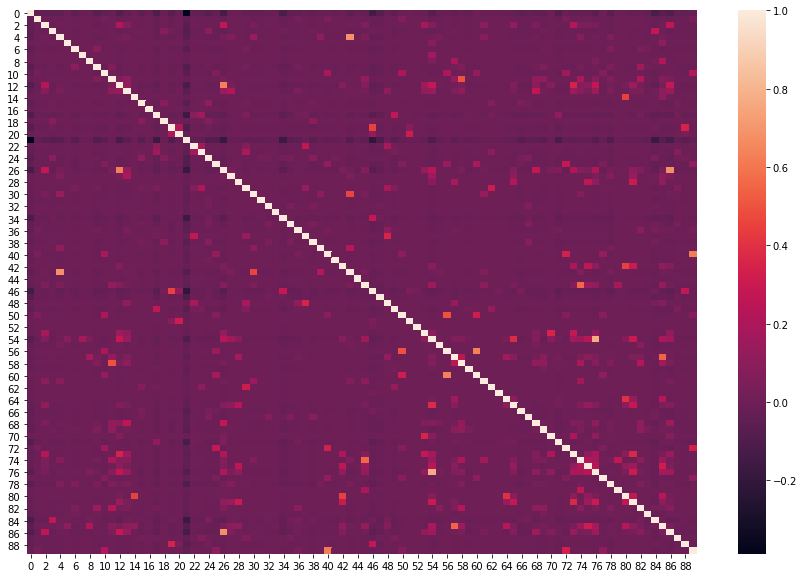

In [728]:
plt.figure(figsize = (15,10))
sns.heatmap(pd.DataFrame(y_train).corr())

In [752]:
# !pip install scikit-multilearn

### Label Powerset Linear SVM

In [1033]:
from skmultilearn.problem_transform import LabelPowerset

In [1034]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', LabelPowerset(LinearSVC(max_iter = 10000)))
])

param_grid = {
#      'clf__classifier__C': [0.1, 1, 10]
}

grid_LP_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LP_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LP_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LP_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LP_LinSVC_tfidf.score(X_test, y_test)}")

Best params: {}
Train accuracy: 0.9819796627622602
Test accuracy: 0.8449817820470354


In [1035]:
y_pred = grid_LP_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LabelPowerSet_LinSVC', y_test, y_pred)

------LabelPowerSet_LinSVC Model Metrics-----
Accuracy: 0.8450
Hamming Loss: 0.0036
Precision:
  - Macro: 0.6969
  - Micro: 0.9064
Recall:
  - Macro: 0.4948
  - Micro: 0.8272
F1-measure:
  - Macro: 0.5438
  - Micro: 0.8650


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Multi Label kNN

In [1036]:
from skmultilearn.adapt import MLkNN

In [1037]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', MLkNN(k=10))
])

param_grid = {
    'clf__k': [7,9,11]
}

grid_ML_kNN_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_ML_kNN_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_ML_kNN_tfidf.best_params_}")
print(f"Train accuracy: {grid_ML_kNN_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_ML_kNN_tfidf.score(X_test, y_test)}")

Best params: {'clf__k': 7}
Train accuracy: 0.8315098468271335
Test accuracy: 0.7671414375621066


In [1038]:
y_pred = grid_ML_kNN_tfidf.best_estimator_.predict(X_test)
metricsReport('MLkNN', y_test, y_pred)

------MLkNN Model Metrics-----
Accuracy: 0.7671
Hamming Loss: 0.0047
Precision:
  - Macro: 0.5576
  - Micro: 0.8670
Recall:
  - Macro: 0.4065
  - Micro: 0.7783
F1-measure:
  - Macro: 0.4500
  - Micro: 0.8203


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Comparison

In [1039]:
# Assign models:
models = []
models.append(('RF tfidf', grid_RF_tfidf.best_estimator_))
models.append(('kNN tfidf', grid_kNN_tfidf.best_estimator_))
models.append(('linSVC tfidf', grid_LinSVC_tfidf.best_estimator_))
models.append(('LP linSVC tfidf`', grid_LP_LinSVC_tfidf.best_estimator_))
models.append(('MLkNN tfidf`', grid_ML_kNN_tfidf.best_estimator_))

# Initiate metrics:
accuracy = []
hamLoss = []
macro_precision = []
macro_recall = []
macro_f1 = []
micro_precision = []
micro_recall = []
micro_f1 = []
auc = []

# Iterate over models and calculate metrics
for name, model in models:
    y_pred = model.predict(X_test)
    
    accuracy.append(accuracy_score(y_test, y_pred))
    hamLoss.append(hamming_loss(y_test, y_pred))
    
    macro_precision.append(precision_score(y_test, y_pred, average='macro'))
    macro_recall.append(recall_score(y_test, y_pred, average='macro'))
    macro_f1.append(f1_score(y_test, y_pred, average='macro'))

    micro_precision.append(precision_score(y_test, y_pred, average='micro'))
    micro_recall.append(recall_score(y_test, y_pred, average='micro'))
    micro_f1.append(f1_score(y_test, y_pred, average='micro'))
 
#     if (name in ['linSVC tfidf']):
#         auc.append(roc_auc_score(y_test , model.decision_function(X_test)))
#     else:
#         auc.append(roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1040]:
d = {'accuracy_score': accuracy, 
     'hamLoss': hamLoss, 
     'macro_precision': macro_precision,
     'micro_precision': micro_precision,
     'macro_recall' : macro_recall,
     'micro_recall' : micro_recall,
     'macro_f1' : macro_f1,
     'micro_f1' : micro_f1
#      'roc_auc_score' : roc_auc_score
    }

df = pd.DataFrame(data=d)
name, _ = zip(*models)
df.insert(loc=0, column='Method', value=name)
df

,Method,accuracy_score,hamLoss,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1
0,RF tfidf,0.679695,0.005554,0.445774,0.959309,0.131130,0.623397,0.184037,0.755707
1,kNN tfidf,0.752236,0.005119,0.619805,0.856623,0.393773,0.754808,0.449770,0.802499
2,linSVC tfidf,0.814839,0.003323,0.639500,0.946839,0.398712,0.803953,0.469395,0.869565
3,LP linSVC tfidf`,0.844982,0.003559,0.696936,0.906351,0.494810,0.827190,0.543839,0.864963
4,MLkNN tfidf`,0.767141,0.004700,0.557589,0.867004,0.406514,0.778312,0.449981,0.820267


### Take the best classifier and search over tfidf params:

In [819]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
    'vectorizer__min_df' : [1],
    'vectorizer__max_df' : [0.5, 0.6, 0.7, 5, 10],
    'vectorizer__ngram_range' : [(1,1), (1,2)]
#     'clf__estimator__C': [1]
}

grid_LinSVC_tfidf_minmax = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf_minmax.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf_minmax.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf_minmax.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf_minmax.score(X_test, y_test)}")

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 70 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37

Best params: {'vectorizer__max_df': 0.6, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Train accuracy: 0.9764448448963831
Test accuracy: 0.8148393507784034


In [820]:
y_pred = grid_LinSVC_tfidf_minmax.best_estimator_.predict(X_test)
metricsReport('LP_LinSVC_tfidf', y_test, y_pred)

------LP_LinSVC_tfidf Model Metrics-----
Accuracy: 0.8148
Hamming Loss: 0.0034
Precision:
  - Macro: 0.6281
  - Micro: 0.9458
Recall:
  - Macro: 0.3927
  - Micro: 0.8018
F1-measure:
  - Macro: 0.4624
  - Micro: 0.8679


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Changing tfidf min/max params has minor influence on results

In [831]:
from sklearn.neural_network import MLPClassifier

In [840]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer()),
    ('clf', MLPClassifier(hidden_layer_sizes=3, max_iter=1000))
])

param_grid = {
#     'vectorizer__min_df' : [1],
#     'vectorizer__max_df' : [0.5, 0.6, 0.7, 5, 10],
#     'vectorizer__ngram_range' : [(1,1), (1,2)]
# #     'clf__estimator__C': [1]
}

grid_MLP_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_MLP_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_MLP_tfidf.best_params_}")
print(f"Train accuracy: {grid_MLP_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_MLP_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best params: {}
Train accuracy: 0.6416527223580899
Test accuracy: 0.5531632991056641


In [842]:
y_pred = grid_MLP_tfidf.best_estimator_.predict(X_test)
metricsReport('MLP_tfidf', y_test, y_pred)

------MLP_tfidf Model Metrics-----
Accuracy: 0.5532
Hamming Loss: 0.0075
Precision:
  - Macro: 0.0884
  - Micro: 0.9128
Recall:
  - Macro: 0.0447
  - Micro: 0.5061
F1-measure:
  - Macro: 0.0516
  - Micro: 0.6512


### CNN in Keras

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


#### 0-layer neural network

In [943]:
X_train_tfidf[0]

<1x20197 sparse matrix of type '<class 'numpy.float64'>'
	with 147 stored elements in Compressed Sparse Row format>

In [911]:
model = Sequential()
model.build()
model.add(Dense(units=y_test.shape[1], input_shape = (X_train_tfidf.shape[1],), activation="sigmoid"))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 90)                1817820   
Total params: 1,817,820
Trainable params: 1,817,820
Non-trainable params: 0
_________________________________________________________________


In [912]:
es = EarlyStopping(patience = 4,
                  monitor = 'val_loss',
                  restore_best_weights=True)

model.fit(X_train_tfidf, y_train, 
         batch_size=16,
         epochs=10,
         callbacks=[es],
         validation_split = 0.2)

Train on 6215 samples, validate on 1554 samples
Epoch 1/10
4784/6215 [======================>.......] - ETA: 2s - loss: 5.2214 - categorical_accuracy: 0.5840

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test_tfidf)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0
metricsReport('CNN_tfidf', y_test, y_pred)

#### Smallest convolutional network

In [6]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(X_train_tfidf.shape[1], 1), ))
model.add(Dense(units=y_train.shape[1], activation="sigmoid" ))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['categorical_accuracy'])
model.summary()

NameError: name 'X_train_tfidf' is not defined

In [939]:
X_train_tfidf.shape

(7769, 20197)

In [938]:
es = EarlyStopping(patience = 4,
                  monitor = 'val_loss',
                  restore_best_weights=True)

model.fit(temp_train, y_train, 
         batch_size=16,
         epochs=10,
         callbacks=[es],
         validation_split = 0.2)

ValueError: Error when checking input: expected conv1d_13_input to have 3 dimensions, but got array with shape (1, 1)

#### Explanation of micro and macro average for multiclass:
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin